# Import data

In [1]:
#First we have the importation part so we need some library to import locally our data

import pandas as pd
import os
import glob

#And the rest of the imports for the data analysis

#import numpy as np
import astral
import datetime
from astral import sun
#from astral import LocationInfo
#from astral import location
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='myapplication')
from timezonefinder import TimezoneFinder
tf = TimezoneFinder()
import pytz
from datetime import tzinfo
import matplotlib.pyplot as plt
import math
from scipy import stats

In [2]:
# Let's create a function that does take the columns we want in our analysis and return a DataFrame with those columns needed.

FOLDER = 'raw/'
csvfiles = glob.glob(os.path.join(FOLDER, '*.csv'))

"""
def import_files(data, columns) :
    #We needed to import data as chunk for the big files as they contain too many rows to be read once
    chunksize = 10 ** 6
    for csvfile in csvfiles:
        for chunk in pd.read_csv(csvfile, usecols=lambda x: x in columns, chunksize=chunksize, low_memory=False, error_bad_lines = False):
            # if we need the state for our analysis we retrieve it from the csv name file
            if 'state' in columns :
                chunk['state'] = csvfile[4:6]
            # same for the county name, except that statewide csv files do contain a column for the county but some csv file are from a single county and 
            # thus the county name is in the csv file name
            if 'county_name' in columns : 
                if 'county_name' not in chunk.columns:
                    end=0
                    for i in range(len(csvfile)) :
                        if csvfile[i].isdigit() :
                            end = i
                            break
                    county_name = csvfile[7:end]
                    county_name = county_name.replace('_', ' ')
                    chunk['county_name']=county_name
            # Finally we can concatenate the DataFrame with the new data read
            data = pd.concat([data, chunk], axis=0 , ignore_index=True, sort=False)
    return data
"""

# First let's import the data with the required columns for our analysis 
data = pd.DataFrame(columns=['date', 'time', 'county_name', "state", 'subject_race', 'officer_race', 'search_conducted', 'contraband_found'])

chunksize = 10 ** 6
for csvfile in csvfiles:
    for chunk in pd.read_csv(csvfile, usecols=lambda x: x in ['date', 'time', 'county_name', 'subject_race', 'officer_race', 'search_conducted', 'contraband_found'] \
                     , chunksize=chunksize, low_memory=False, error_bad_lines = False):
        states = [csvfile[4:6].upper() for i in range(len(chunk))]
        chunk.insert(2, "state", states)
        data = pd.concat([data, chunk], axis=0 , ignore_index=True)
data

C:\Users\james\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,contraband_found,county_name,date,officer_race,search_conducted,state,subject_race,time
0,NaN,NaN,2008-10-10,hispanic,NaN,CA,hispanic,NaN
1,NaN,NaN,2008-10-10,white,NaN,CA,hispanic,NaN
2,NaN,NaN,2008-10-10,white,NaN,CA,hispanic,NaN
3,NaN,NaN,2008-10-10,white,NaN,CA,white,NaN
4,NaN,NaN,2008-10-10,white,NaN,CA,hispanic,NaN
...,...,...,...,...,...,...,...,...
29212666,NaN,NaN,2018-09-21,NaN,False,WA,NaN,14:00:00
29212667,NaN,NaN,2018-09-25,NaN,False,WA,NaN,09:00:00
29212668,NaN,NaN,2018-09-26,NaN,False,WA,NaN,09:00:00
29212669,NaN,NaN,2018-09-26,NaN,False,WA,NaN,13:00:00


# Part 1 : Veil of darkness test

In [3]:
# First let's take from the data the columns we're interested in for this analysis
columns = ['date', 'time', 'state', 'subject_race', 'officer_race']
df_veil = data[columns]

# And remove the columns where there are no informations about the subject race, the officer race and the time and date of the stop as we will base our analysis on those
df_veil = df_veil.dropna(subset=['date', 'time', 'subject_race', 'officer_race'])

# The dataset contain some data about Asian/Pacifican race people but we will remove them from our analysis as they are only a small fraction 
# of the population. For the Veil of darkness test we will also remove hispanic drivers and thus officer because the ethnicity of Hispanic drivers
# is not always apparent, even in daylight hours.
df_veil = df_veil.query('subject_race in ["white", "black"] and officer_race in ["white", "black"]')


# Finally we'll convert the date to datetime format for further work with it
# Convert date to datetime
df_veil['date'] = pd.to_datetime(df_veil['date'], format = "%Y/%m/%d")

df_veil

,date,time,state,subject_race,officer_race
365925,2010-01-06,16:14:43,FL,white,black
365926,2010-01-08,19:39:31,FL,white,white
365927,2010-01-11,11:56:34,FL,white,white
365930,2010-01-15,09:18:02,FL,white,white
365931,2010-01-15,10:16:59,FL,hispanic,white
...,...,...,...,...,...
26136758,2015-09-18,10:00:00,WA,white,white
26136759,2015-09-20,12:00:00,WA,white,white
26136760,2015-09-21,10:00:00,WA,white,white
26136761,2015-09-21,14:00:00,WA,asian/pacific islander,white


In [4]:
# To test for the veil of darkness we will need to search for the sunset time at each day of the year at each state in our analysis. 
# As it's a big search we need to reduce computation time and because sunset is at the same time though the year, we can safely remove
# the year of the stop to keep only the day and month of the stop to then search for the sunset at this time of the year.
df_veil['date'] = df_veil['date'].apply(lambda x: x.strftime('%m-%d'))
df_veil

,date,time,state,subject_race,officer_race
365925,01-06,16:14:43,FL,white,black
365926,01-08,19:39:31,FL,white,white
365927,01-11,11:56:34,FL,white,white
365930,01-15,09:18:02,FL,white,white
365931,01-15,10:16:59,FL,hispanic,white
...,...,...,...,...,...
26136758,09-18,10:00:00,WA,white,white
26136759,09-20,12:00:00,WA,white,white
26136760,09-21,10:00:00,WA,white,white
26136761,09-21,14:00:00,WA,asian/pacific islander,white


In [5]:
# Also, for the sunset search, we will need a complete date with also the year, we will add 2016 to the date as it's a year that goes until 
# the 29th of february and this date is in our dataset.
df_veil['date'] = df_veil['date'].apply(lambda x : '2016-'+x)

# And we can put back the date in datetime format
df_veil['date'] = pd.to_datetime(df_veil['date'], format="%Y/%m/%d")
df_veil

,date,time,state,subject_race,officer_race
365925,2016-01-06,16:14:43,FL,white,black
365926,2016-01-08,19:39:31,FL,white,white
365927,2016-01-11,11:56:34,FL,white,white
365930,2016-01-15,09:18:02,FL,white,white
365931,2016-01-15,10:16:59,FL,hispanic,white
...,...,...,...,...,...
26136758,2016-09-18,10:00:00,WA,white,white
26136759,2016-09-20,12:00:00,WA,white,white
26136760,2016-09-21,10:00:00,WA,white,white
26136761,2016-09-21,14:00:00,WA,asian/pacific islander,white


In [6]:
# Let's now create our sunset dataset where we need the sunset for each state and each day of the year
df_sunset = df_veil.groupby(['state', 'date']).count().reset_index()[['state', 'date']]

# Let's find the states we have in our dataset to then find the geocode location with help of the geolocator library. This geocode will help us find the timezone 
# of the US we're in and also the sunset time with help of the astral library
states = df_sunset['state'][df_sunset['state'].duplicated(keep='first') == False].to_list()
locations = []
timezones = []
astr = []
# Let's find all locations of the states
for i in states  :
    locations.append(geolocator.geocode(i+' USA'))
    
# And then find the timezone and the astral object of this location
for location in locations : 
    timezones.append(pytz.timezone(tf.timezone_at(lng=location.longitude, lat=location.latitude)))
    astr.append(astral.Observer(latitude = location.latitude, longitude = location.longitude))

# Finally we need to add sunset time of each state and date in the DataFrame where stops have been grouped by state and date
sunset=[]
for row in df_sunset.iterrows() :
    index = states.index(row[1]['state'])
    sunset.append(sun.sunset(astr[index], date=row[1]['date'], tzinfo = timezones[index]))

# And append it to the sunset DataFrame with the date in datetime format
df_sunset['sunset']=[sunset[i].time() for i in range(len(sunset))]
df_sunset['date']=pd.to_datetime(df_sunset['date'], format = "%Y/%m/%d")

df_sunset

,state,date,sunset
0,FL,2016-01-01,17:41:45.493173
1,FL,2016-01-02,17:42:26.700927
2,FL,2016-01-03,17:43:08.686556
3,FL,2016-01-04,17:43:51.408405
4,FL,2016-01-05,17:44:34.824605
...,...,...,...
1825,WA,2016-12-27,16:17:01.678300
1826,WA,2016-12-28,16:17:49.681238
1827,WA,2016-12-29,16:18:40.080350
1828,WA,2016-12-30,16:19:32.820701


In [7]:
# Let's look at our sunset dataset and see when are the minimum and maximum values for sunset in our choosen states  
sunset_min = df_sunset['sunset'].min()
sunset_max = df_sunset['sunset'].max()
print(f'Minimum sunset time  {sunset_min}, Maximum sunset time : {sunset_max}')

Minimum sunset time  16:10:11.928757, Maximum sunset time : 21:13:45.831757


In [8]:
# As we have still a big dataset and the veil of darkness analysis takes only time that are maximum 2 hours before sunset 
# and maximum 2h30 after sunset. We take a bigger time after sunset because of the 30 inutes window time between sunset and dusk.
length_before = len(df_veil)
df_veil['time'] = [datetime.datetime.strptime(df_veil['time'].iloc[i], '%H:%M:%S') for i in range(len(df_veil))]
df_veil = df_veil.loc[(df_veil['time']>datetime.datetime.strptime("14:10:00", '%H:%M:%S')) & (df_veil['time']<(datetime.datetime.strptime("23:43:00", '%H:%M:%S')))]
length_after = len(df_veil)

print(f'The dataset has been shorten by {length_before-length_after} rows and we now have {length_after} rows.')

The dataset has been shorten by 5639439 rows and we now have 3951880 rows.


In [9]:
# We will just need to further modify the DataFrame to have the time as a pydatetime format and the date as a datetime
df_veil['time']= [df_veil['time'].iloc[i].to_pydatetime() for i in range(len(df_veil))]
df_veil['date'] = [df_veil.iloc[i]['date'].strftime("%Y-%m-%d") for i in range(len(df_veil))]

C:\Users\james\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\james\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Now let's define the DataFrame we will work on for the analysis. This DataFrame will contain the subject race, the officer race and the time
# to sunset. If the stop happened 2 hours before sunset, the time_sunset column will be -7200 as we change it to seconds. 

#To create this Dat$aFrame, we will need to iterate over each row of the df_veil DataFrame to find the corresponding state and day of the year in
# the sunset DataFrame to compare the time of the stop to the time of the sunset at this place and time of the year.


df_veil_sunset = pd.DataFrame(columns = ['subject_race', 'officer_race', 'time_sunset'])
for row in df_veil.iterrows() :
    sunset = df_sunset.loc[(df_sunset['state'] == row[1]['state']) & (df_sunset['date'] == row[1]['date']), 'sunset'].values[0].strftime("%H:%M:%S")
    time_sunset = (row[1]['time'] - datetime.datetime.strptime(sunset, '%H:%M:%S')).total_seconds()
    df_veil_sunset = df_veil_sunset.append({'subject_race' : row[1]['subject_race'], 'officer_race' : row[1]['officer_race'], 'time_sunset' : time_sunset}, ignore_index = True)
df_veil_sunset

In [ ]:
#df_veil_sunset.to_csv(r'data_clean/df_veil_sunset.csv', index=False)

In [13]:
df_veil_sunset = pd.read_csv('data_clean/df_veil_sunset.csv')
df_veil_sunset

,subject_race,officer_race,time_sunset
0,white,black,-5435.0
1,white,white,6763.0
2,white,white,18604.0
3,black,black,-11386.0
4,black,black,-9054.0
...,...,...,...
3187166,white,white,10488.0
3187167,white,white,14088.0
3187168,white,white,-10990.0
3187169,white,white,4264.0


In [14]:
# Now to start analysing the sunset Dataset we will remove first the data where the sunset doesn't lie in the the interval of 90 minutes 
# before sunset and 30 to 120 minutes after sunset. This will then allow us to compare stops before and after sunset. 
df_veil_sunset = df_veil_sunset.loc[(df_veil_sunset['time_sunset']>-5400) & (df_veil_sunset['time_sunset']<7200)]
df_veil_sunset = df_veil_sunset.loc[(df_veil_sunset['time_sunset']<0) | (df_veil_sunset['time_sunset']>1800)]

# Let's round time to the upper 10's of minutes
df_veil_sunset['time_sunset'] = df_veil_sunset['time_sunset'].apply(lambda x : int(math.ceil(x / 600.0)) * 10)

# We can now get the sum of the number of stops by subject race per officer race with the different time between sunset
df_veil_sunset = pd.get_dummies(df_veil_sunset, columns=['subject_race'])
df_veil_sunset=df_veil_sunset.groupby(['officer_race', 'time_sunset']).sum()

# In the plot we will use the number of stops as the size of the datapoints. We can thus add a column with the sum of sunset by row for indication
# in our DataFrame. We will also use percentage of total stops per time and per officer race to compare between driver's race. 
sum_row_list = [] #for the size of the rounds
sum_row = 0
for row in df_veil_sunset.iterrows() :
    sum_row = row[1]['subject_race_black']+row[1]['subject_race_white']
    row[1]['subject_race_black']/= sum_row
    row[1]['subject_race_white']/= sum_row
    sum_row_list.append(sum_row)
df_veil_sunset['sum_row']=sum_row_list
df_veil_sunset = df_veil_sunset.reset_index()

df_veil_sunset

,officer_race,time_sunset,subject_race_black,subject_race_white,sum_row
0,black,-80,0.269740,0.730260,6117.0
1,black,-70,0.266656,0.733344,6229.0
2,black,-60,0.271339,0.728661,5764.0
3,black,-50,0.263618,0.736382,5838.0
4,black,-40,0.277122,0.722878,5503.0
5,black,-30,0.276185,0.723815,5337.0
6,black,-20,0.277282,0.722718,4930.0
7,black,-10,0.276902,0.723098,5074.0
8,black,0,0.301558,0.698442,4364.0
9,black,40,0.277322,0.722678,2928.0


In [15]:
#Let's define a function to plot the veil of darkness test. We will add mean and standard deviations to the datapoints.

def draw(ax, df, race_officer, race_subject, sum_row_list, size) : 
    df_veil_draw = df.loc[df['officer_race']==race_officer]
    list_sizes = df_veil_draw['sum_row'].copy()
    list_sizes[:] = [x/size for x in list_sizes]
    ax.scatter(df_veil_draw['time_sunset'], df_veil_draw[race_subject], s=list_sizes)
    mean_before = df_veil_draw.loc[df_veil_draw['time_sunset']<=0].mean()[race_subject]
    mean_after = df_veil_draw.loc[df_veil_draw['time_sunset']>=30].mean()[race_subject]
    std_before = df_veil_draw.loc[df_veil_draw['time_sunset']<=0].std()[race_subject]
    std_after = df_veil_draw.loc[df_veil_draw['time_sunset']>=30].std()[race_subject]
    ax.hlines(mean_before, xmin=-80, xmax=0, colors='k', linestyles='solid')
    ax.hlines(mean_after, xmin=30, xmax=120, colors='k', linestyles='solid')
    ax.hlines(mean_before+std_before, xmin=-80, xmax=0, colors='k', linestyles='--')
    ax.hlines(mean_after+std_after, xmin=30, xmax=120, colors='k', linestyles='--')
    ax.hlines(mean_before-std_before, xmin=-80, xmax=0, colors='k', linestyles='--')
    ax.hlines(mean_after-std_after, xmin=30, xmax=120, colors='k', linestyles='--')
    ax.axvline(0)
    ax.axvline(30)
    ax.set_title(f'Officer : {race_officer}, Driver : {race_subject[13:]}')
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90, 120])
    return []

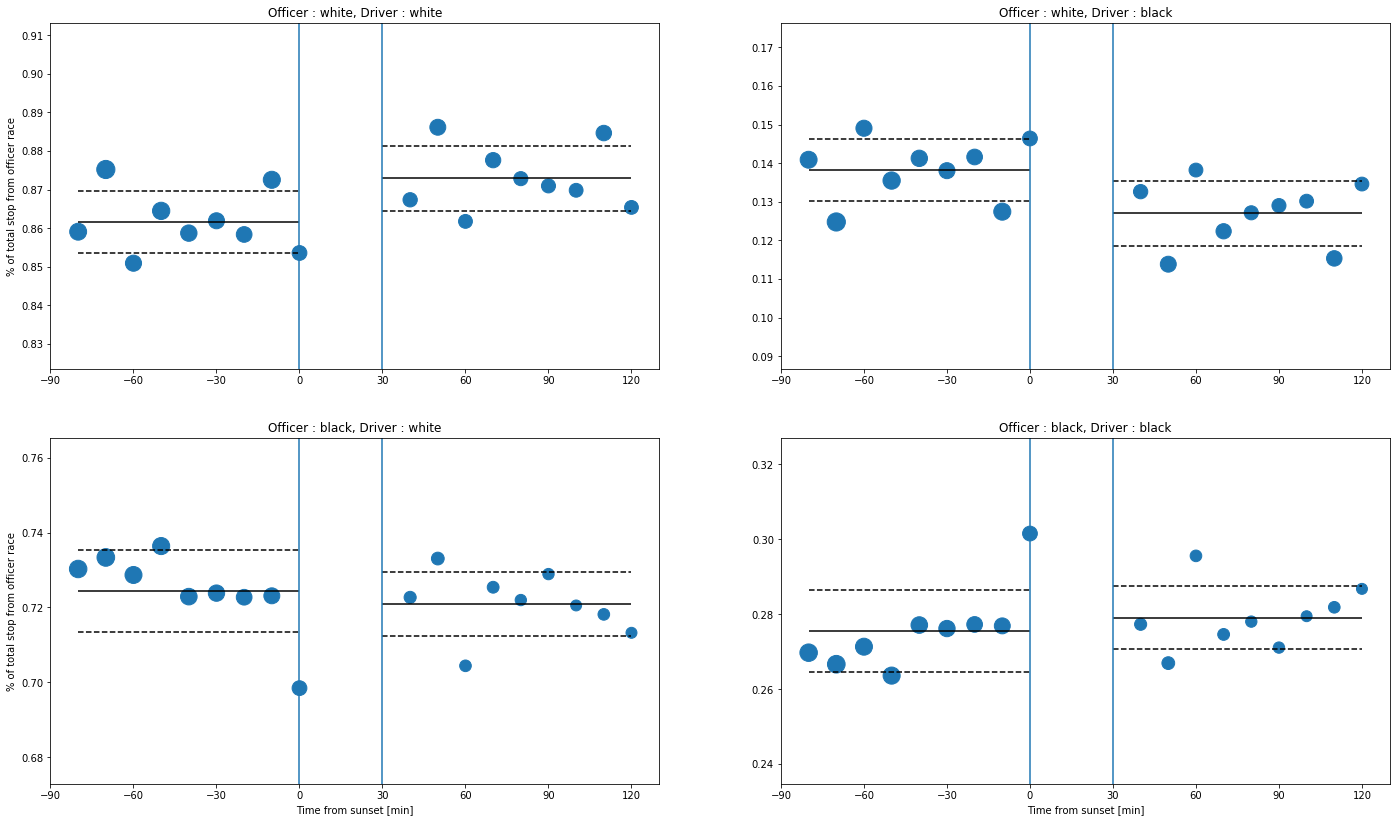

In [16]:
# Let's plot now the dataset
fig = plt.figure(figsize=(24, 14))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

draw(ax1 , df_veil_sunset, 'white', 'subject_race_white', sum_row_list, 200)
draw(ax2 , df_veil_sunset, 'white', 'subject_race_black', sum_row_list, 200)

draw(ax3 , df_veil_sunset, 'black', 'subject_race_white', sum_row_list, 20)
draw(ax4 , df_veil_sunset, 'black', 'subject_race_black', sum_row_list, 20)

ax3.set_xlabel('Time from sunset [min]')
ax4.set_xlabel('Time from sunset [min]')
ax1.set_ylabel('% of total stop from officer race')
ax3.set_ylabel('% of total stop from officer race')

plt.show()

In [59]:
#let's define now a function for the t-test for the difference in means
def ttest(data, races):
    df = pd.DataFrame(columns=['officer_race', 'driver_race', 'mean_before', 'mean_after', 't-statistic', 'p-value'])
    for officer_race in races:
        for driver_race in races :
            data_test = data.loc[data['officer_race']==officer_race]
            data_before = data_test.loc[data_test['time_sunset']<=0]['subject_race_'+driver_race]
            data_after = data_test.loc[data_test['time_sunset']>=30]['subject_race_'+driver_race]
            result = stats.ttest_ind(data_before, data_after)
            temp = pd.DataFrame([[officer_race, driver_race, data_before.mean(), data_after.mean(), result[0], result[1]]], columns=df.columns)
            df = pd.concat([df, temp], ignore_index=True)
    return df

In [60]:
#And now use it to test our data
races=['white', 'black']
ttest_veil = ttest(df_veil_sunset, races)
ttest_veil.head(10)

,officer_race,driver_race,mean_before,mean_after,t-statistic,p-value
0,white,white,0.861658,0.872962,-2.921739,0.009980
1,white,black,0.138342,0.127038,2.921739,0.009980
2,black,white,0.724400,0.720917,0.755128,0.461144
3,black,black,0.275600,0.279083,-0.755128,0.461144
